In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
import scipy
from scipy import signal

import uuid
import os
import pywt


## Load the data

In [2]:
data=pd.read_csv('dataset_processed.csv')#  preprocessed data without label
labels=pd.read_csv('data.csv')#labels
data_processed=pd.concat((data,labels['label']),axis=1)

## SCALOGRAM

### One signal exemple 

Here we're goig to plot different scalograms using different wavelet famelies

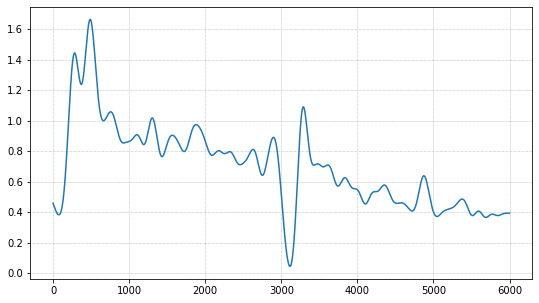

In [3]:

t = np.linspace(0, 6000, 6000)
signal = data.iloc[1]
plt.figure(figsize=(9, 5))
plt.plot(t, signal)
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

We need to choose a wavelet from all the wavelet families available , to do so let's test which one fits the most our signal

Below we can see a plot with several different families of wavelets.

The first row contains four Discrete Wavelets and the second row four Continuous Wavelets.

c:\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


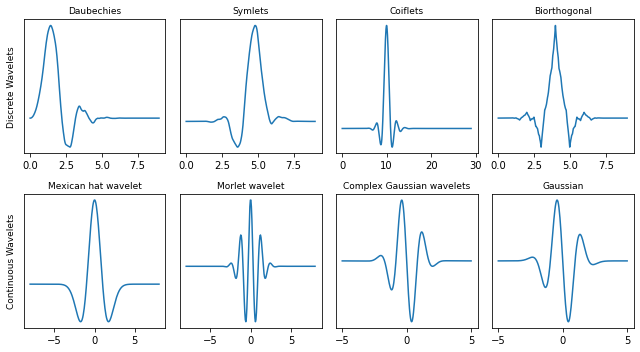

In [13]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']
 
list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]
 
fig, axarr = plt.subplots(nrows=2, ncols=4, figsize=(9,5))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=9)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=9)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=9)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])
 
plt.tight_layout()
plt.show()

In [146]:
## create folders
# folder for each wavelet transform
wavelet='mexican hat wavelet scalogram'
for i in data_processed['label'].unique():
    os.makedirs("{}/{}".format(wavelet,i)) 

In [ ]:
data_processed[data_processed['label']=='Hook']

In [14]:
for i in range(750,900):
    filename = str(uuid.uuid4())
    signal = data.iloc[i]
    scales = np.arange(1,700)
    coefs, freqs = pywt.cwt(signal, scales, 'mexh')
    fig,ax = plt.subplots(1,1)
#hide x-axis
    ax.get_xaxis().set_visible(False)
#hide y-axis 
    ax.get_yaxis().set_visible(False)
    ax.imshow(coefs, aspect='auto')
    plt.savefig("mexican hat wavelet scalogram/hook1/{}.png".format(filename),bbox_inches='tight')
    plt.close()

In [ ]:
for i in data.index:
    filename = str(uuid.uuid4())
    signal = data.iloc[i]
    scales = np.arange(1,700)
    coefs, freqs = pywt.cwt(signal, scales, 'mexh')
    fig,ax = plt.subplots(1,1)
#hide x-axis
    ax.get_xaxis().set_visible(False)
#hide y-axis 
    ax.get_yaxis().set_visible(False)
    ax.imshow(coefs, aspect='auto')
    plt.savefig("mexican hat wavelet scalogram/{}/{}.png".format(data_processed['label'][i],filename),bbox_inches='tight')
    plt.close()

## hey

In [59]:
import splitfolders
## we're gonna split the wavelet data folder into train val and test folders 
splitfolders.ratio("mexican hat wavelet scalogram", output="mxh split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
# note:Set move=True if you want to move the files instead of copying.

In [3]:
from pathlib import Path
# Define path to the data directory
data_dir = Path('.\mxh split')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

We will first go through the training dataset. We will do some analysis on that, look at some of the samples, check the number of samples for each class, etc. Lets' do it.

Each of the above directory contains two sub-directories:
 add the classes here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [24]:
# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator
# create generator
datagen = ImageDataGenerator()
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory(train_dir, target_size=(224, 224),class_mode='categorical',batch_size=64)
val_it = datagen.flow_from_directory(val_dir, target_size=(224, 224),class_mode='categorical',batch_size=64)
test_it = datagen.flow_from_directory(test_dir, target_size=(224, 224),class_mode='categorical',batch_size=64)
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 717 images belonging to 6 classes.
Found 89 images belonging to 6 classes.
Found 91 images belonging to 6 classes.
Batch shape=(64, 224, 224, 3), min=0.000, max=255.000


The constructor for the ImageDataGenerator contains many arguments to specify how to manipulate the image data after it is loaded, including pixel scaling and data augmentation.

## Models

In [8]:
import tensorflow as tf
def create_cnn_model():

    model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(6,activation='softmax')  
    ])


    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']) 


    return model

In [9]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0

In [25]:
# Train the model

cnn_train = cnn_model.fit(train_it,
                    epochs=1,
                    verbose=True,
                    validation_data=val_it,
                    steps_per_epoch= 64,
                    validation_steps= 20)

64/64 [==============================] - 69s 1s/step - loss: 1.4904 - accuracy: 0.3445 - val_loss: 1.3902 - val_accuracy: 0.4270


## Resnet50

In [19]:
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
resnet_50 = Sequential()

resnet_50.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet')) # ,input_shape=(224,224,3)

resnet_50.add(Dense(1024, activation = 'relu'))
resnet_50.add(Dense(512, activation = 'relu'))
resnet_50.add(Dense(128, activation = 'relu'))
resnet_50.add(Dense(64, activation = 'relu'))
resnet_50.add(Dense(6, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
resnet_50.layers[0].trainable = False

In [20]:

resnet_50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 26,284,998
Trainable params: 2,697,286
N

In [21]:
from tensorflow.keras import optimizers
resnet_50.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), 
                  loss = keras.losses.CategoricalCrossentropy(from_logits = True), 
                  metrics = ['accuracy'])

In [23]:
resnet_history = resnet_50.fit_generator(
        train_it,
        steps_per_epoch=23,
        epochs = 5,
        validation_data=val_it,
        validation_steps=20
)

Epoch 1/5


C:\Users\massy\AppData\Local\Temp\ipykernel_14516\2491549097.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_history = resnet_50.fit_generator(


23/23 [==============================] - 132s 6s/step - loss: 1.5881 - accuracy: 0.2762 - val_loss: 1.5770 - val_accuracy: 0.3596
Epoch 2/5
23/23 [==============================] - 96s 4s/step - loss: 1.5327 - accuracy: 0.2929
Epoch 3/5
23/23 [==============================] - 104s 5s/step - loss: 1.4303 - accuracy: 0.3835
Epoch 4/5
23/23 [==============================] - 116s 5s/step - loss: 1.3859 - accuracy: 0.3961
Epoch 5/5
23/23 [==============================] - 92s 4s/step - loss: 1.3973 - accuracy: 0.3891
